In [1]:
import numpy as np
import matplotlib.pyplot as plt
from few.waveform import FastKerrEccentricEquatorialFlux, GenerateEMRIWaveform
from few.waveform.base import SphericalHarmonicWaveformBase
from few.utils.constants import Gpc, MRSUN_SI, YRSID_SI
from typing import Optional, Union, Callable

use_gpu = False #False if your computer sucks (mine does)

from deriv_angles import viewing_angle_partials, fplus_fcross_derivs

if not use_gpu:
    
    import few
    
    #tune few configuration
    cfg_set = few.get_config_setter(reset=True)
    
    cfg_set.enable_backends("cpu")
    cfg_set.set_log_level("info");
else:
    pass #let the backend decide for itself.

In [2]:
def _available_stencils():
    """
    Accessed from #Fornberg 1988: https://doi.org/10.1090%2FS0025-5718-1988-0935077-0
    """
    
    return {
        "central": {
            2: np.asarray([-1/2, 1/2]),
            4: np.asarray([1/12, -2/3, 2/3, -1/12]),
            6: np.asarray([-1/60, 3/20, -3/4, 3/4, -3/20, 1/60]),
            8: np.asarray([1/280, -4/105, 1/5, -4/5, 4/5, -1/5, 4/105, -1/280])
        },
        "forward": {
            2: np.asarray([-3/2, 2, -1/2]),
            4: np.asarray([-25/12, 4, -3, 4/3, -1/4]),
            6: np.asarray([-49/20, 6, -15/2, 20/3, -15/4, 6/5, -1/6]),
            8: np.asarray([-761/280, 8, -14, 56/3, -35/2, 56/5, -14/3, 8/7, -1/8]) 
        },
        "backward": {
            2: np.asarray([1/2, -2, 3/2]),
            4: np.asarray([1/4, -4/3, 3, -4, 25/12]),
            6: np.asarray([1/6, -6/5, 15/4, -20/3, 15/2, -6, 49/20]),
            8: np.asarray([1/8, -8/7, 14/3, -56/5, 35/2, -56/3, 14, -8, 761/280])
        }
    }

class StableEMRIDerivative(GenerateEMRIWaveform):
    """
        inherits from the GenerateEMRIWaveform class of FEW, adds functions for derivative calculation and a fresh __call__ method.
    """
    def __init__(
        self,
        waveform_class,
        *args,
        frame: str = "detector",
        return_list = False,
        flip_output = False,
        **kwargs,
    ):
        super().__init__(waveform_class=waveform_class, 
                         *args, 
                         frame=frame, 
                         return_list=return_list, 
                         flip_output=flip_output, 
                         **kwargs) #initialize GenerateEMRIWaveform
        self.cache = None #initialize waveform cache

    def __getattr__(self, name):
        # get_attributes from self.waveform_generator if not found in GenerateEMRIWaveform
        return getattr(self.waveform_generator, name)

    def __call__(
        self,
        m1,
        m2,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
        *add_args,
        **kwargs, #should have parameters (dict), param_to_vary (str), delta (float), order (int), kind (str) 
    ):
        """
        generate the waveform derivative for the given parameter
        """

        try:
            parameters = kwargs['parameters']
            param_to_vary = kwargs['param_to_vary']
            self.delta = kwargs['delta']
            self.order = kwargs['order']
            self.kind = kwargs['kind']
            
        except KeyError as e:
            raise ValueError(f"kwargs must include {e}")

        if self.kind not in ["central", "forward", "backward"]:
            raise ValueError('kind must be one of "central", "forward", or "backward".')
        if self.order not in [2, 4, 6, 8]:
            raise ValueError('order must be one of 2, 4, 6, or 8.')

        #construct deltas for derivative
        self.deltas = self._deltas(self.delta, self.order, self.kind)

        # how we proceed depends on the parameter we are differentiating with respect to
        if param_to_vary not in parameters:
            raise ValueError(f"Parameter '{param_to_vary}' not in parameters dictionary.")

        try:
            T = kwargs['T']
        except KeyError:
            T = 1.0

        try:
            dt = kwargs['dt']
        except KeyError:
            dt = 10.0

        #obtain source frame angles
        theta_source, phi_source = self._get_viewing_angles(parameters['qS'],
                                                            parameters['phiS'],
                                                            parameters['qK'],
                                                            parameters['phiK'])
        parameters['theta_source'] = theta_source
        parameters['phi_source'] = phi_source

        keys_exclude = ['parameters', 'param_to_vary', 'delta', 'order', 'kind', 'T', 'dt']
        kwargs_remaining = {key: value for key, value in kwargs.items() if key not in keys_exclude}

        #get waveform
        if self.cache is None or parameters != self.cache['parameters']:
            t, y = self._trajectory_from_parameters(parameters, T)

            self.cache = {
                't':t,
                'y':y,
                'parameters':parameters,
                'coefficients':self.inspiral_generator.integrator_spline_coeff,
                'phase_coefficients':self.xp.asarray(self.inspiral_generator.integrator_spline_phase_coeff)[:, [0,2], :],
                'phase_coefficients_t':self.xp.asarray(self.inspiral_generator.integrator_spline_t),
            }

            amps_here = self._amplitudes_from_trajectory(parameters, t = t, y = y, cache=True, **kwargs_remaining)

            #create waveform at injection
            waveform_source = self.create_waveform(
                self.cache['t'],
                amps_here, #actually teuk_amps * Ylms_in
                self.cache['dummy_ylms'], #a bunch of ones
                self.cache['phase_coefficients_t'],
                self.cache['phase_coefficients'],
                self.cache['ls_all'],
                self.cache['ms_all'],
                #self.cache['ks_all'], #no inclination in FEW 2.0 :(
                self.cache['ns_all'],
                dt=dt,
                T=T,
                **kwargs_remaining,
            )

            self.cache['waveform_source'] = waveform_source

        # now calculate the derivatives with respect to the chosen parameters

        # distance
        if param_to_vary == 'dist':
            waveform_derivative_source = - self.cache['waveform_source'] / parameters['dist']

        # phases
        elif param_to_vary in ['Phi_phi0', 'Phi_theta0', 'Phi_r0']:
            # factor of -1j*m is applied to each amplitude
            modified_amps = self._modify_amplitudes_for_initial_phase_derivative(param_to_vary)
            
            # create waveform derivative
            waveform_derivative_source = self.create_waveform(
                self.cache['t'],
                modified_amps,
                self.cache['dummy_ylms'],
                self.cache['phase_coefficients_t'],
                self.cache['phase_coefficients'],
                self.cache['ls_all'],
                self.cache['ms_all'],
                #self.cache['ks_all'],
                self.cache['ns_all'],
                dt=dt,
                T=T,
                **kwargs_remaining,
            )

        # sky angles (SSB)
        elif param_to_vary in ['qS', 'phiS', 'qK', 'phiK']:
            # finite differencing of the ylms w.r.t. theta, then chain rule partial h / partial theta * partial theta / partial angle
            modified_amps = self._modify_amplitudes_for_angle_derivative(parameters, param_to_vary)
            
            waveform_derivative_source = self.create_waveform(
                    self.cache['t'],
                    modified_amps,
                    self.cache['dummy_ylms'],
                    self.cache['phase_coefficients_t'],
                    self.cache['phase_coefficients'],
                    self.cache['ls_all'],
                    self.cache['ms_all'],
                    #self.cache['ks_all'],
                    self.cache['ns_all'],
                    dt=dt,
                    T=T,
                    **kwargs_remaining,
                )

        # traj params
        else:
            #if you've reached this point, a derivative w.r.t one of the trajectory parameters is requested.
            #trajectory must be modified
            #get trajectories
            y_interps = self.xp.full((len(self.deltas), self.cache['t'].size, len(self.cache['y'])), self.xp.nan) #trajectory for each of the finite difference deltas
            
            for k, delt in enumerate(self.deltas):
                parameters_in = parameters.copy()
                parameters_in[param_to_vary] += delt #perturb by finite-difference
                t, y = self._trajectory_from_parameters(parameters_in, T)
                #re-interpolate onto the time-step grid for the injection trajectory
                t_interp = self.cache['t'].copy()

                if t_interp[-1] > t[-1]: #the perturbed trajectory is plunging. Add NaN's at the end!
                    mask_notplunging = t_interp < t[-1] #for all t_interp < t[-1], the perturbed trajectory is still not plunging
                    t_interp = t_interp[mask_notplunging]
                
                y_interp = self.xp.asarray(self.inspiral_generator.inspiral_generator.eval_integrator_spline(t_interp).T) #any unfilled elements due to plunging trajectories assume nans.
                y_interps[k,:len(t_interp)] = y_interp.T

                #print("y_interps[k][xI] (before removing nans): ", y_interps[k,:,2])
                
            # In the case of plunge, some trajectories will be shorter than others. They appear as NaN's in the y_interps array
            nans = self.xp.isnan(y_interps)
            #print("nans:", nans)
            if nans.any():
                max_ind = self.xp.where(nans.sum(2).sum(0) > 0)[0].min()
            else:
                max_ind = y_interp.shape[1]
            #print("max_ind: ", max_ind, "y_interp.shape: ", y_interp.shape[1])
            
            # modify size of the trajectories and phases accordingly
            t_interp = self.cache['t'][:max_ind]   
            y_interps = y_interps[:, :max_ind, :]
            phases_steps = y_interps[:,:,3:6] #Phi_phi, Phi_theta, Phi_r
            phase_coefficients = self.xp.asarray(self.cache['phase_coefficients'][:max_ind - 1, :])
            phase_t = self.xp.asarray(self.cache['phase_coefficients_t'][:max_ind])
            
            #finite differencing the phases
            dPhi_fund_dx = self._stencil(phases_steps, self.delta, self.order, self.kind)
            #project the fundamental phases up to the full mode index space
            dPhi_dx = (dPhi_fund_dx[:,0,None] * self.cache['ms_all'][None,:] + 
                       #dPhi_fund_dx[:,1,None] * self.cache['ks_all'][None,:] + #no inclination in FEW 2.0
                       dPhi_fund_dx[:,2,None] * self.cache['ns_all'][None,:])

            #get amplitude derivative
            amps_steps = self.xp.zeros((len(self.deltas), max_ind,  len(self.cache['ls_all'])), dtype=self.xp.complex128)

            for k, delt in enumerate(self.deltas):

                #### DO WE NEED TO ITERATE? NOT IN OG CODE FROM CHRISTIAN ###########
                parameters_in = parameters.copy()
                parameters_in[param_to_vary] += delt #perturb by finite-difference
                #####################################################################
                #print("y_interps[k][xI]: ", y_interps[k].T[2])
                amps_here = self._amplitudes_from_trajectory(parameters_in, t_interp, y_interps[k].T, cache=False, **kwargs_remaining) #remember, this function multiplies by Ylmns!
                amps_steps[k] = amps_here

            #finite differencing the amplitudes
            dAmp_dx = self._stencil(amps_steps, self.delta, self.order, self.kind) #actually d teuk_amps/dx * Ylmns

            #defining effective amplitudes = dAdx - i A dPhidx
            wave_amps = self.cache['teuk_modes_with_ylms'][:max_ind]
            effective_amps = dAmp_dx - 1j * wave_amps * dPhi_dx

            if param_to_vary in ['m1', 'm2']: #additional term due to chain rule of dist_dimensionless
                mu = parameters['m1'] * parameters['m2'] / (parameters['m1'] + parameters['m2'])
                M = parameters['m1'] + parameters['m2']
                if param_to_vary == 'm1': 
                    dmu_dm = parameters['m2'] ** 2 / (M ** 2)
                else:
                    dmu_dm = parameters['m1'] ** 2 / (M ** 2)
                effective_amps += wave_amps / mu * dmu_dm

            #create derivative
            waveform_derivative_source = self.create_waveform(
                t_interp,
                effective_amps, #actually effective amplitudes * Ylmns
                self.cache['dummy_ylms'], #just a bunch of ones
                phase_t,
                phase_coefficients,
                self.cache['ls_all'],
                self.cache['ms_all'],
                #self.cache['ks_all'],
                self.cache['ns_all'],
                dt=dt,
                T=T,
                **kwargs_remaining,
            )

            # pad with zeroes if required to get back to the waveform length
            if max_ind < self.cache['t'].size:
                waveform_derivative_source = np.concatenate(
                    (
                        waveform_derivative_source, 
                        np.zeros((self.cache['waveform_source'].size - waveform_derivative_source.size), 
                                 dtype=waveform_derivative_source.dtype)
                    ), 
                axis=0)

        #waveform derivative obtained in the source frame. Now we must transform to detector (SSB) frame 
        #and apply antenna patterns (and its derivatives in case of qS, phiS, qK, phiK)

        if self.waveform_generator.frame == "source":
            waveform_derivative_source *= -1

        #decompose to plus and cross
        (waveform_derivative_source_plus, 
         waveform_derivative_source_cross) = (waveform_derivative_source.real,
                                              -waveform_derivative_source.imag)

        if self.frame == "source":
            if self.return_list is False:
                return waveform_derivative_source_plus - 1j * waveform_derivative_source_cross
            else:
                return [waveform_derivative_source_plus, waveform_derivative_source_cross]

        #detector frame requested; apply antenna pattern
        (waveform_derivative_detector_plus, 
         waveform_derivative_detector_cross) = self._to_SSB_frame(hp = waveform_derivative_source_plus, 
                                                                  hc = waveform_derivative_source_cross,
                                                                  qS = parameters['qS'], phiS = parameters['phiS'], 
                                                                  qK = parameters['qK'], phiK = parameters['phiK'])

        #if derivative is with respect to one of the angles, also need derivatives with antenna pattern
        if param_to_vary in ['qS', 'phiS', 'qK', 'phiK']:
            antenna_derivs = fplus_fcross_derivs(qS, phiS, qK, phiK, with_respect_to=param_to_vary)

            waveform_derivative_detector_plus += (antenna_derivs[f'dFplusI/d{param_to_vary}'] * waveform_derivative_source_plus +
                                                  antenna_derivs[f'dFcrossI/d{param_to_vary}'] * waveform_derivative_source_cross)

            waveform_derivative_detector_cross += (antenna_derivs[f'dFplusII/d{param_to_vary}'] * waveform_derivative_source_plus +
                                                  antenna_derivs[f'dFcrossII/d{param_to_vary}'] * waveform_derivative_source_cross)
        
        if self.return_list is False:
            return waveform_derivative_detector_plus - 1j * waveform_derivative_detector_cross
        else:
            return [waveform_derivative_detector_plus, waveform_derivative_detector_cross]
    
    def clear_cache(self):
        self.cache = None #reset cache
            
    def _trajectory_from_parameters(self, parameters, T):
    
        """
        calculate the inspiral trajectory over time T (years) for a given set of parameters.
    
        Args:
            parameters (dict): dictionary of parameters with the param name as key and its value as value.
            T (float): time (in years) for the inspiral trajectory
        Returns:
            t (np.ndarray): time steps (in seconds) of the trajectory
            y (np.ndarray): evolving parameters of the trajectory along the time grid
        """
        
        traj = self.inspiral_generator(
            parameters['m1'],
            parameters['m2'],
            parameters['a'],
            parameters['p0'],
            parameters['e0'],
            parameters['xI0'],
            Phi_phi0 = parameters['Phi_phi0'],
            Phi_theta0 = parameters['Phi_theta0'],
            Phi_r0 = parameters['Phi_r0'],
            T = T,
            **self.inspiral_kwargs,
        ) #generate the trajectory
    
        t = traj[0]
        y = traj[1:]
    
        #convert for gpus
        t = self.xp.asarray(t)
        y = self.xp.asarray(y)
    
        return t, y

    def _amplitudes_from_trajectory(self, parameters, t, y, cache=False, **kwargs):
        """
        calculate the amplitudes (and ylms) from the trajectory.

        Args:
            parameters (dict): dictionary of trajectory parameters
            t (np.ndarray): array of time steps for trajectory
            y (np.ndarray): array of evolving parameters in the trajectory at time steps
            cache (bool): whether to cache info (True) or not (False)
        Returns:
            Teukolsky amplitudes times Ylms
        """

        #if detector frame, scale by distance in the amplitude module as well.
        if self.frame == 'detector':
            mu = parameters['m1'] * parameters['m2'] / (parameters['m1'] + parameters['m2'])
            dist_dimensionless = (parameters['dist'] * Gpc) / (mu * MRSUN_SI)
        else:
            dist_dimensionless = 1.0 
            
        if cache:
            mode_selection = None
        else:
            mode_selection = self.cache['mode_selection']

        #get teuk amplitudes, ylms, ls, ms, ks, and ns from the mode_selector module.

        #ylms
        ylms = self.ylm_gen(self.unique_l, self.unique_m, parameters['theta_source'], parameters['phi_source']).copy()[self.inverse_lm]
        
        # amplitudes
        teuk_modes = self.xp.asarray(
            self.amplitude_generator(parameters['a'], *y[:3])
        )

        modeinds = [self.l_arr, 
                    self.m_arr,
                    self.n_arr]
        modeinds_map = self.special_index_map_arr
        
        (
            teuk_modes_in,
            ylms_in,
            self.ls,
            self.ms,
            self.ns,
        ) = self.mode_selector(
            teuk_modes,
            ylms,
            modeinds,
            mode_selection = mode_selection, #None in first pass, but selects a given set of modes in subsequent passes
            modeinds_map = modeinds_map, #only used when mode_selection is a list.
            **kwargs
        )

        if cache:
            #we don't use mode symmetry
            m0mask = self.ms != 0
            teuk_modes_in = self.xp.concatenate(
                (teuk_modes_in, (-1)**(self.ls[m0mask])*self.xp.conj(teuk_modes_in[:, m0mask])), axis=1
            )

            ylms_in = self.xp.concatenate(
                (ylms_in[:self.ls.size], ylms_in[self.ls.size:][m0mask]), axis=0
            )

            self.cache['ls_all'] = self.xp.concatenate(
                (self.ls, self.ls[m0mask]),
                axis=0
            )
            self.cache['ms_all'] = self.xp.concatenate(
                (self.ms, -self.ms[m0mask]),
                axis=0
            )

            ######### NO INCLINATION IN FEW 2.0 :( ################
            #self.cache['ks_all'] = self.xp.concatenate(
            #    (self.ks, -self.ks[m0mask]),
            #    axis=0
            #)
            #######################################################
            
            self.cache['ns_all'] = self.xp.concatenate(
                (self.ns, -self.ns[m0mask]),
                axis=0
            )

            self.cache['ls'] = self.ls.copy()
            self.cache['ms'] = self.ms.copy()
            #self.cache['ks'] = self.ks.copy()
            self.cache['ns'] = self.ns.copy()

            self.cache['mode_selection'] = [
                (l, 
                 m, 
                 n) for l, m, n in zip(
                    self.cache['ls'], 
                    self.cache['ms'], 
                    self.cache['ns']
                )
            ]

            self.cache['teuk_modes'] = teuk_modes_in / dist_dimensionless
            self.cache['teuk_modes_with_ylms'] = self.cache['teuk_modes'] * ylms_in
            self.cache['ylms_in'] = ylms_in
            self.cache['dummy_ylms'] = self.xp.ones(2 * teuk_modes_in.shape[1], dtype=self.xp.complex128)
            self.cache['dummy_ylms'][teuk_modes_in.shape[1]:] = 0.0
            self.cache['m0mask'] = m0mask

            return self.cache['teuk_modes_with_ylms']
                
        else:
            teuk_modes_in = self.xp.concatenate(
                (teuk_modes_in, (-1)**(self.ls[self.cache['m0mask']])*self.xp.conj(teuk_modes_in[:, self.cache['m0mask']])), axis=1
            )

            ylms_in = self.xp.concatenate(
                (ylms_in[:self.ls.size], ylms_in[self.ls.size:][self.cache['m0mask']]), axis=0
            )

            return teuk_modes_in * ylms_in / dist_dimensionless

    def _modify_amplitudes_for_initial_phase_derivative(self, param_to_vary):
        """ 
        calculates modified amplitudes for phase derivatives.

        Args:
            param_to_vary (string): one of "Phi_phi0", "Phi_theta0", "Phi_r0"
        returns
            modified amplitudes = -i (mode_index) A
        """

        if param_to_vary == 'Phi_phi0':
            factor = -1j * self.cache['ms_all']
        elif param_to_vary == 'Phi_theta0':
            raise NotImplementedError #no inclination in FEW 2.0
        elif param_to_vary == 'Phi_r0':
            factor = -1j * self.cache['ns_all']

        modified_amps = self.cache['teuk_modes_with_ylms'] * factor[None, :]
        return modified_amps

    def _modify_amplitudes_for_angle_derivative(self, parameters, param_to_vary):
        """
        calculates modified amplitudes for angle derivatives (qS, phiS, qK, phiK)

        Args:
            parameters (dict): model parameters
            param_to_vary (str): one of qS, phiS, qK, phiK: parameter with respect to which to calculate the derivative
        Returns:
            modified amplitudes = A * partial Y_lm / partial theta * partial_theta / partial kappa where kappa is the param_to_vary
        """

        ylm_temp = np.zeros((len(self.deltas), self.cache['ls_all'].size), dtype=np.complex128)

        #first calculate dylm_dtheta
        for k, delt in enumerate(self.deltas):
            parameters_in = parameters.copy()
            parameters_in['theta_source'] += delt
            # get the ylms for this theta
            ylm_temp[k] = self.ylm_gen(self.cache['ls_all'], self.cache['ms_all'], parameters_in['theta_source'], parameters_in['phi_source'])

        dYlm_dtheta = self._stencil(ylm_temp, self.delta, self.order, self.kind)

        #now calculate dtheta_dkappa
        if param_to_vary == 'qS':
            key_dtheta_dkappa = "del theta_src / del qS"
        elif param_to_vary == 'phiS':
            key_dtheta_dkappa = "del theta_src / del phi_S"
        elif param_to_vary == 'qK':
            key_dtheta_dkappa = "del theta_src / del qK"
        elif param_to_vary == 'phiK':
            key_dtheta_dkappa = "del theta_src / del phi_K"
        
        dtheta_dkappa = viewing_angle_partials(qS, phiS, qK, phiK)[key_dtheta_dkappa]

        # modify the amplitudes by the derivative of the Ylms
        modified_amps = self.cache['teuk_modes'] * dYlm_dtheta[None, :] * dtheta_dkappa

        return modified_amps

    def _deltas(self, delta, order, kind):
        """
            return the np.ndarray of parameter deltas for a given delta

        Args:
            delta (float): finite-difference delta
            order (int): order of derivative. Choose from 2, 4, 6, 8
            kind (str): kind of derivative. Choose from "central", "forward", "backward"
        """

        if kind == "central":
            # symmetric positions around 0, excluding 0
            half = order // 2
            positions = list(range(-half, 0)) + list(range(1, half + 1))
    
        elif kind == "forward":
            positions = list(range(order + 1))
    
        elif kind == "backward":
            positions = list(range(-order, 1))

        return np.asarray(positions) * delta

    def _stencil(self, func_steps, delta, order, kind):
        """
            return the stencil for finite-differences

        Args:
            func_steps (np.ndarray): array of function at different steps of the finite-difference deltas grid
            order (int): order of finite-difference derivative. Choose from 2, 4, 6, 8
            kind (str): kind of finite-difference derivative. Choose from "central", "forward", "backward"
        """

        return np.tensordot(_available_stencils()[kind][order], func_steps, axes = (0,0)) / delta

In [3]:
waveform_derivative = StableEMRIDerivative(waveform_class=FastKerrEccentricEquatorialFlux,
                                          mode_selector_kwargs=dict(mode_selection_threshold=1e-3), 
                                          inspiral_kwargs=dict(err=1e-11, max_iter=10000))

In [27]:
m1 = 1e6
m2 = 1e1
a = 0.
p0 = 9.5
e0 = 0.4
xI0 = 1.0
dist = 0.5
qS = np.pi/3
phiS = np.pi/4
qK = np.pi/6
phiK = np.pi/8
Phi_phi0 = np.pi/2
Phi_theta0 = 0.0
Phi_r0 = 0.0

T = 0.1
dt = 10.0

pars_list = [m1, m2, a, p0, e0, xI0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
param_names = ['m1','m2','a','p0','e0','xI0','dist','qS','phiS','qK','phiK','Phi_phi0','Phi_theta0','Phi_r0']

parameters = {}
for i in range(len(param_names)):
    parameters[param_names[i]] = pars_list[i]

param_to_vary = 'Phi_r0'

delta = 1e-8  #finite difference delta for the chosen paramete
order = 4 #order of finite-difference derivative
kind = "central" #kind of finite-difference derivative

der = waveform_derivative(*pars_list, T = T, dt = dt, 
                    parameters = parameters, 
                    param_to_vary = param_to_vary,
                    delta = delta,
                    order = order,
                    kind = kind)

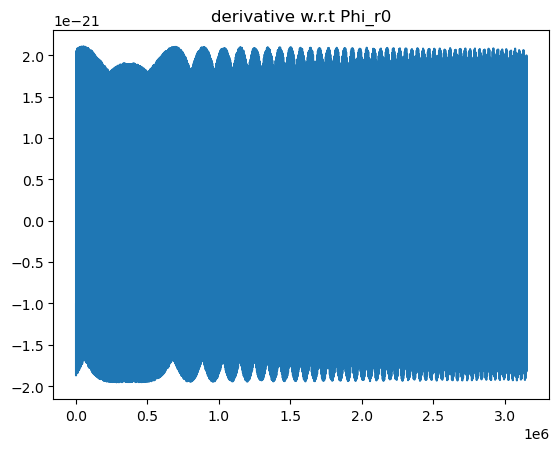

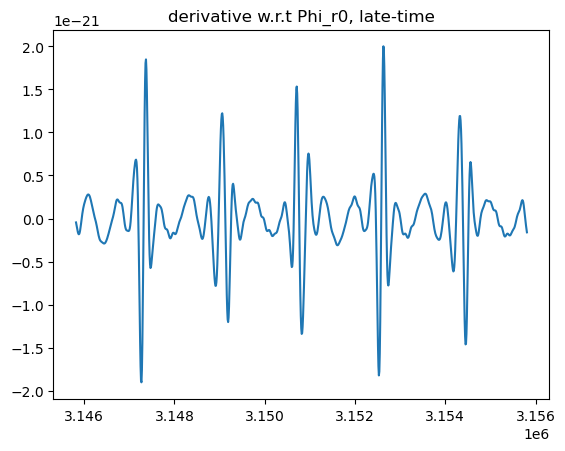

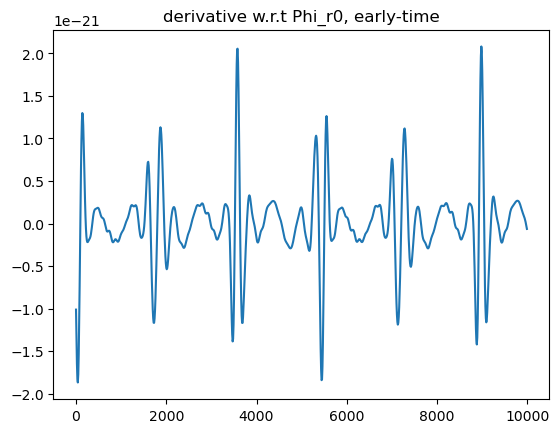

In [28]:
times = np.arange(len(der))*dt
plt.plot(times, der.real)
plt.title(f"derivative w.r.t {param_to_vary}")
plt.show()

times = np.arange(len(der))*dt
plt.plot(times[-1000:], der.real[-1000:])
plt.title(f"derivative w.r.t {param_to_vary}, late-time")
plt.show()

plt.plot(times[:1000], der.real[:1000])
plt.title(f"derivative w.r.t {param_to_vary}, early-time")
plt.show()

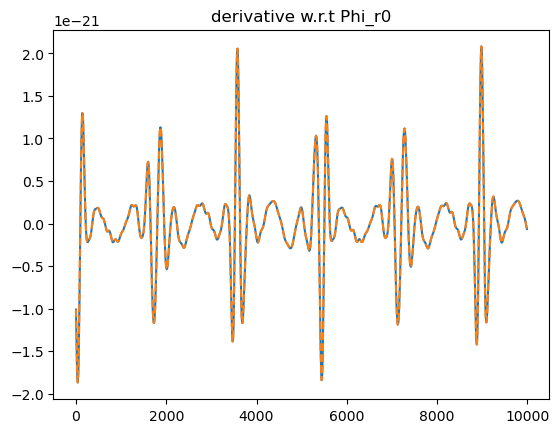

In [29]:
#compare with a different order and kind

order = 2 #order of finite-difference derivative
kind = "forward" #kind of finite-difference derivative

der_2nd = waveform_derivative(*pars_list, T = T, dt = dt, 
                    parameters = parameters, 
                    param_to_vary = param_to_vary,
                    delta = delta,
                    order = order,
                    kind = kind)

times = np.arange(len(der))*dt
plt.plot(times[:1000], der.real[:1000])
times = np.arange(len(der_2nd))*dt
plt.plot(times[:1000], der_2nd.real[:1000], '--')
plt.title(f"derivative w.r.t {param_to_vary}")
plt.show()

### Compare with finite difference derivative of the waveform itself

In [8]:
wave_gen_base = GenerateEMRIWaveform(
    FastKerrEccentricEquatorialFlux,
    mode_selector_kwargs=dict(mode_selection = waveform_derivative.cache['mode_selection']), 
    inspiral_kwargs=dict(err=1e-11, max_iter=10000)
    )

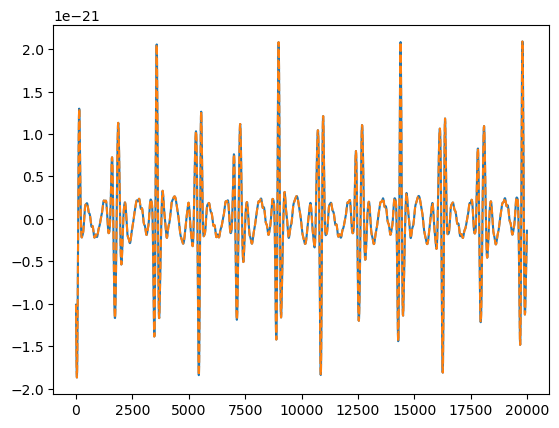

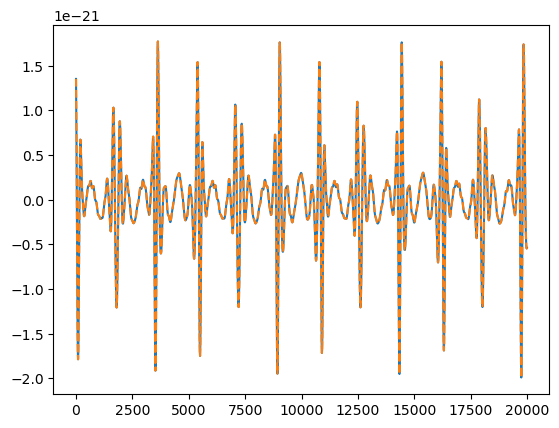

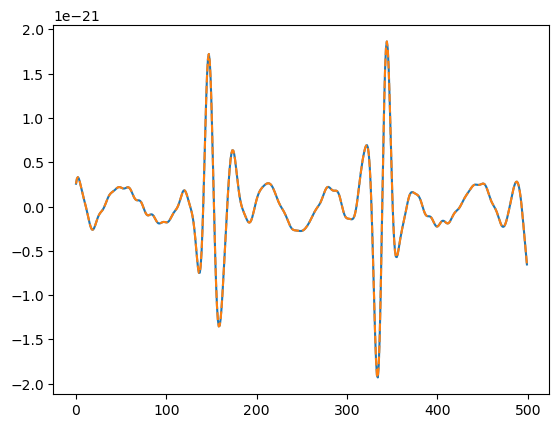

In [30]:
# compute the derivative manually
wavdelts = []

for delta in waveform_derivative.deltas:
    parameters_in = parameters.copy()
    parameters_in[param_to_vary] += delta
    wave = wave_gen_base(
        parameters_in['m1'],
        parameters_in['m2'],
        parameters_in['a'],
        parameters_in['p0'],
        parameters_in['e0'],
        parameters_in['xI0'],
        parameters_in['dist'],
        parameters_in['qS'],
        parameters_in['phiS'],
        parameters_in['qK'],
        parameters_in['phiK'],
        Phi_phi0 = parameters_in['Phi_phi0'],
        Phi_theta0 = parameters_in['Phi_theta0'],
        Phi_r0 = parameters_in['Phi_r0'],
        dt=dt, 
        T=T,
    )
    if len(wave) < len(der_2nd):
        wave = np.concatenate(
            (wave, np.zeros((der_2nd.size - wave.size), dtype=wave.dtype)*np.nan),
            axis=0
        )
    else:
        wave = wave[:der_2nd.size]
    wavdelts.append(wave)

deriv_man = waveform_derivative._stencil(wavdelts, waveform_derivative.delta, waveform_derivative.order, waveform_derivative.kind)

plt.plot(times[:2000], der_2nd.real[0:2000])
plt.plot(times[:2000], deriv_man.real[0:2000], '--')
plt.show()

plt.plot(times[:2000], der_2nd.imag[0:2000])
plt.plot(times[:2000], deriv_man.imag[0:2000], '--')
plt.show()

plt.plot(der_2nd.real[20000:20500])
plt.plot(deriv_man.real[20000:20500], '--')
plt.show()

In [10]:
#potentially problematic parameters log: m2, qS, phiS, qK, phiK